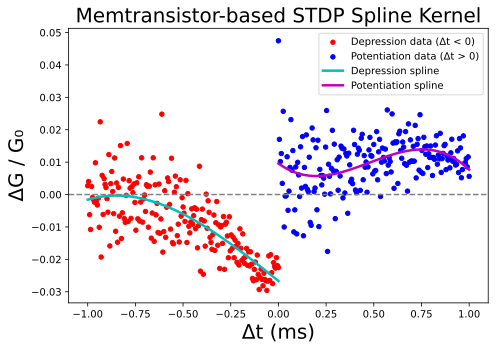

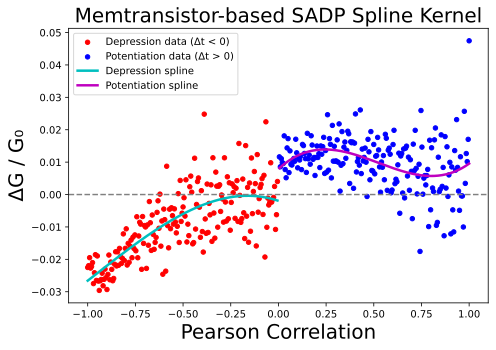

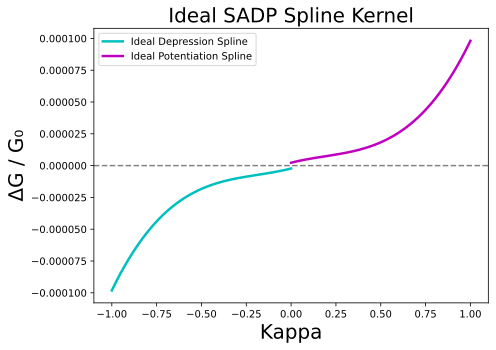

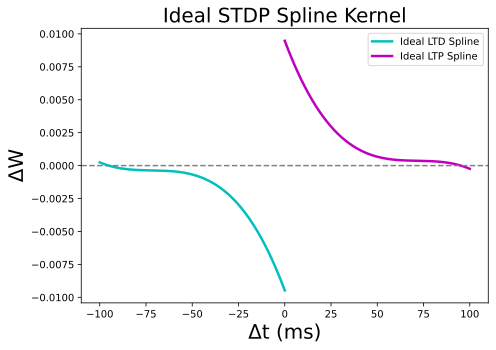

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score
%run SCDP_functions.ipynb

In [2]:
# ---------------- HELPERS ----------------
def extract_spike_count_features(model, x_spike, batch_size=128, timesteps=10):
    """
    Run the SNN model on spike-encoded inputs and return spike-count features.
    Assumes the SNN model returns output with shape (N, neurons, timesteps) or (N, timesteps, neurons).
    Returns:
      features: np.array shape (N, neurons) = spike counts per neuron across timesteps
      raw: raw output array shape (N, neurons, timesteps)
    """
    out = model.predict(x_spike, batch_size=batch_size, verbose=0)
    if tf.is_tensor(out):
        out = out.numpy()
    if out.ndim != 3:
        raise ValueError(f"Expected 3D output from SNN (N,neurons,timesteps) or (N,timesteps,neurons). Got shape {out.shape}")
    # If shape is (N, timesteps, neurons), swap
    if out.shape[1] == timesteps and out.shape[2] != timesteps:
        out = np.transpose(out, (0, 2, 1))  # -> (N, neurons, timesteps)
    # Sum over timesteps to get spike-count per neuron
    spike_counts = out.sum(axis=-1)  # (N, neurons)
    return spike_counts, out

def safe_unpack_sadp_return(sadp_ret, total_wall_time, epochs):
    """
    Accept flexible SADP return types.
    Preferred SADP return: (w_norms_list, per_epoch_times_list)
    If only w_norms_list is returned, compute avg epoch time = total_wall_time / epochs.
    Returns (w_norms_list, per_epoch_times_list)
    """
    # Default fallback
    avg_epoch = total_wall_time / epochs if epochs > 0 else total_wall_time
    if sadp_ret is None:
        return [], [avg_epoch] * epochs

    # If it's a tuple/list with two elements and second is list-like -> interpret directly
    if isinstance(sadp_ret, (tuple, list)) and len(sadp_ret) == 2:
        w_norms, per_epoch_times = sadp_ret
        # If the second is a scalar (unexpected), fallback
        if np.isscalar(per_epoch_times):
            per_epoch_times = [float(per_epoch_times)] * epochs
        return list(w_norms), list(per_epoch_times)

    # If it's list/array -> treat as w_norms only
    if isinstance(sadp_ret, (list, np.ndarray)):
        return list(sadp_ret), [avg_epoch] * epochs

    # Otherwise unknown -> fallback empty
    return [], [avg_epoch] * epochs

# ---------------- BENCHMARK RUNNER ----------------
def run_full_benchmark(encoding_name, model_type, sadp_method):
    print(f"\n=== Testing {encoding_name} | {model_type} | {sadp_method.__name__} ===")

    # 1) Spike encoding function
    encode_fn = rate_coding if encoding_name == 'rate' else ttfs_coding
    x_train_spike = encode_fn(x_train, timesteps)  # expected shape depends on your SNN input
    x_test_spike  = encode_fn(x_test, timesteps)

    # Convert to tf tensors only if your model expects them (many do)
    x_train_spike_tf = tf.convert_to_tensor(x_train_spike)
    x_test_spike_tf  = tf.convert_to_tensor(x_test_spike)

    # 2) Build SNN
    if model_type == '1layer_small':
        model = build_snn_1layer_small(num_timesteps=timesteps)
    elif model_type == '1layer':
        model = build_snn_1layer(num_timesteps=timesteps)
    else:
        raise ValueError("Unknown model_type: " + str(model_type))

    # Force build by running a single sample if necessary
    try:
        _ = model(x_train_spike_tf[:1])
    except Exception:
        # Some SNN models might not take TF tensors; try numpy
        try:
            _ = model(x_train_spike[:1])
        except Exception:
            pass

    # 3) Prepare SADP args
    sadp_args = {
        'model': model,
        'x_train': x_train_spike_tf,
        'y_train': (rate_code_labels(y_train_cat, timesteps) if encoding_name == 'rate'
                    else ttfs_code_labels(y_train_cat, timesteps)),
        'epochs': sadp_epochs,
        'batch_size': batch_size,
        'learning_rate': sadp_lr,
        'V_thresh': V_thresh
    }
    if sadp_method.__name__ == 'train_on_chip_spline':
        sadp_args.update({'spline_pot': spline_pot, 'spline_dep': spline_dep})
    elif sadp_method.__name__ == 'train_on_chip_spline_ideal':
        sadp_args.update({'spline_pot_ideal': spline_pot_ideal, 'spline_dep_ideal': spline_dep_ideal})

    # 4) Run SADP and time
    t0 = time.time()
    sadp_ret = sadp_method(**sadp_args)  # user-provided function; prefer returning (w_norms, per_epoch_times)
    total_sadp_time = time.time() - t0

    # Unpack SADP return safely
    w_norms, per_epoch_times = safe_unpack_sadp_return(sadp_ret, total_sadp_time, sadp_epochs)
    # ensure lengths
    if len(per_epoch_times) != sadp_epochs:
        per_epoch_times = ([float(total_sadp_time) / sadp_epochs] * sadp_epochs)

    # 5) Extract features: spike-count per neuron
    # we call model.predict on all data and sum across timesteps
    # if model expects TF tensors, pass those; otherwise pass numpy arrays
    try:
        train_feats, train_raw = extract_spike_count_features(model, x_train_spike_tf, batch_size=batch_size, timesteps=timesteps)
        test_feats, test_raw = extract_spike_count_features(model, x_test_spike_tf, batch_size=batch_size, timesteps=timesteps)
    except Exception:
        # fallback to numpy arrays
        train_feats, train_raw = extract_spike_count_features(model, x_train_spike, batch_size=batch_size, timesteps=timesteps)
        test_feats, test_raw = extract_spike_count_features(model, x_test_spike, batch_size=batch_size, timesteps=timesteps)

    # Validate feature dims
    #assert train_feats.ndim == 2 and train_feats.shape[1] == n_hidden, \
    #    f"Expected features shape (N, {n_hidden}). Got {train_feats.shape}"

    # 6) Downstream classifier (simple dense)
    classifier = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(train_feats.shape[1],)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

    hist = classifier.fit(train_feats, y_train_cat, validation_data=(test_feats, y_test_cat),
                          epochs=classifier_epochs, batch_size=batch_size, verbose=1)

    # Evaluate and metrics
    y_pred_prob = classifier.predict(test_feats, batch_size=batch_size, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    test_acc = accuracy_score(y_test, y_pred)
    test_f1  = f1_score(y_test, y_pred, average='macro')

    return {
        'sadp_time_total': total_sadp_time,
        'per_epoch_times': per_epoch_times,
        'test_accuracy': float(test_acc),
        'test_f1': float(test_f1),
        'W_norms': list(w_norms),
        'History': hist.history,
        'model': model
    }

In [3]:
# CONFIG
tf.config.optimizer.set_jit(True)
dataset_name = "fmnist"   
timesteps = 10
sadp_epochs = 10
classifier_epochs = 50
batch_size = 64
sadp_lr = 0.1
V_thresh = 0.5

# DATA
if dataset_name == "mnist":
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
else:
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# TEST CASES
test_cases = [
    # (encoding_name, model_type, sadp_method)
    ('rate', '1layer_small', train_on_chip_linear),
    ('rate', '1layer_small', train_on_chip_spline),
    ('rate', '1layer_small', train_on_chip_spline_ideal),
    ('ttfs', '1layer_small', train_on_chip_linear),
    ('ttfs', '1layer_small', train_on_chip_spline),
    ('ttfs', '1layer_small', train_on_chip_spline_ideal),
    ('rate', '1layer', train_on_chip_linear),
    ('rate', '1layer', train_on_chip_spline),
    ('rate', '1layer', train_on_chip_spline_ideal),
    ('ttfs', '1layer', train_on_chip_linear),
    ('ttfs', '1layer', train_on_chip_spline),
    ('ttfs', '1layer', train_on_chip_spline_ideal),
]


In [4]:
# MAIN
all_results = []
for encoding, model_type, method in test_cases:
    try:
        res = run_full_benchmark(encoding, model_type, method)
    except Exception as e:
        print(f"ERROR running {encoding}-{model_type}-{method.__name__}: {e}")
        continue

    all_results.append({
        'Model': method.__name__.replace('train_on_chip_', '') + ' SADP',
        'Coding': encoding,
        'Classifier': model_type,
        'Accuracy': res['test_accuracy'],
        'F1': res['test_f1'],
        'Runtime_sec': res['sadp_time_total'],
        'Per_epoch_sec': res['per_epoch_times'],
        'W_norms': res['W_norms'],
        'History': res['History']
    })
    # clear TF session to avoid memory buildup between runs (rebuild next loop)
    tf.keras.backend.clear_session()




=== Testing rate | 1layer_small | train_on_chip_linear ===

Epoch 1/10


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:19<00:00, 47.90it/s]


  Avg Output Spikes: 0.6926
  Final Layer Weight Norm: 157.2926

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:17<00:00, 53.37it/s]


  Avg Output Spikes: 0.6909
  Final Layer Weight Norm: 170.6898

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:17<00:00, 53.29it/s]


  Avg Output Spikes: 0.6880
  Final Layer Weight Norm: 178.8495

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:17<00:00, 53.04it/s]


  Avg Output Spikes: 0.6814
  Final Layer Weight Norm: 184.2728

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:17<00:00, 52.92it/s]


  Avg Output Spikes: 0.6907
  Final Layer Weight Norm: 188.1227

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:17<00:00, 53.18it/s]


  Avg Output Spikes: 0.6998
  Final Layer Weight Norm: 191.0128

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:17<00:00, 53.06it/s]


  Avg Output Spikes: 0.6942
  Final Layer Weight Norm: 193.2083

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:17<00:00, 53.19it/s]


  Avg Output Spikes: 0.6919
  Final Layer Weight Norm: 194.9696

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:17<00:00, 53.07it/s]


  Avg Output Spikes: 0.6902
  Final Layer Weight Norm: 196.4080

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [00:17<00:00, 53.35it/s]


  Avg Output Spikes: 0.6846
  Final Layer Weight Norm: 197.5892
Epoch 1/50
938/938 [==============================] - 2s 1ms/step - loss: 3.0641 - accuracy: 0.1426 - val_loss: 2.1403 - val_accuracy: 0.2605
Epoch 2/50
938/938 [==============================] - 1s 1ms/step - loss: 1.8063 - accuracy: 0.3579 - val_loss: 1.6290 - val_accuracy: 0.4135
Epoch 3/50
938/938 [==============================] - 1s 1ms/step - loss: 1.4692 - accuracy: 0.4663 - val_loss: 1.4070 - val_accuracy: 0.4897
Epoch 4/50
938/938 [==============================] - 1s 1ms/step - loss: 1.3014 - accuracy: 0.5269 - val_loss: 1.2850 - val_accuracy: 0.5330
Epoch 5/50
938/938 [==============================] - 1s 1ms/step - loss: 1.2029 - accuracy: 0.5625 - val_loss: 1.2058 - val_accuracy: 0.5635
Epoch 6/50
938/938 [==============================] - 1s 1ms/step - loss: 1.1378 - accuracy: 0.5868 - val_loss: 1.1532 - val_accuracy: 0.5866
Epoch 7/50
938/938 [==============================] - 1s 1ms/step - loss: 1.0927 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:21<00:00, 42.84it/s]


  Avg Output Spikes: 0.8070
  Final Layer Weight Norm: 131.8716

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:20<00:00, 45.92it/s]


  Avg Output Spikes: 0.7775
  Final Layer Weight Norm: 137.1576

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:19<00:00, 47.11it/s]


  Avg Output Spikes: 0.7030
  Final Layer Weight Norm: 144.4035

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:19<00:00, 47.08it/s]


  Avg Output Spikes: 0.6218
  Final Layer Weight Norm: 151.4770

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:19<00:00, 47.08it/s]


  Avg Output Spikes: 0.5414
  Final Layer Weight Norm: 156.5776

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:20<00:00, 46.72it/s]


  Avg Output Spikes: 0.4758
  Final Layer Weight Norm: 158.3423

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:19<00:00, 47.37it/s]


  Avg Output Spikes: 0.4333
  Final Layer Weight Norm: 158.3745

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:20<00:00, 45.76it/s]


  Avg Output Spikes: 0.4604
  Final Layer Weight Norm: 158.3745

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:20<00:00, 46.33it/s]


  Avg Output Spikes: 0.4566
  Final Layer Weight Norm: 158.3745

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [00:19<00:00, 47.26it/s]


  Avg Output Spikes: 0.4769
  Final Layer Weight Norm: 158.3745
Epoch 1/50
938/938 [==============================] - 2s 1ms/step - loss: 3.3176 - accuracy: 0.1688 - val_loss: 2.6849 - val_accuracy: 0.2199
Epoch 2/50
938/938 [==============================] - 1s 1ms/step - loss: 2.4006 - accuracy: 0.2697 - val_loss: 2.1788 - val_accuracy: 0.3070
Epoch 3/50
938/938 [==============================] - 1s 1ms/step - loss: 2.0067 - accuracy: 0.3444 - val_loss: 1.8878 - val_accuracy: 0.3680
Epoch 4/50
938/938 [==============================] - 1s 1ms/step - loss: 1.7702 - accuracy: 0.4015 - val_loss: 1.7073 - val_accuracy: 0.4145
Epoch 5/50
938/938 [==============================] - 1s 1ms/step - loss: 1.6198 - accuracy: 0.4416 - val_loss: 1.5907 - val_accuracy: 0.4453
Epoch 6/50
938/938 [==============================] - 1s 1ms/step - loss: 1.5205 - accuracy: 0.4700 - val_loss: 1.5125 - val_accuracy: 0.4697
Epoch 7/50
938/938 [==============================] - 1s 1ms/step - loss: 1.4523 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:24<00:00, 37.57it/s]


  Avg Output Spikes: 0.7039
  Final Layer Weight Norm: 129.5248

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 42.44it/s]


  Avg Output Spikes: 0.7049
  Final Layer Weight Norm: 129.5266

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 41.78it/s]


  Avg Output Spikes: 0.7058
  Final Layer Weight Norm: 129.5283

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 41.40it/s]


  Avg Output Spikes: 0.7074
  Final Layer Weight Norm: 129.5301

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 41.98it/s]


  Avg Output Spikes: 0.7135
  Final Layer Weight Norm: 129.5319

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 42.21it/s]


  Avg Output Spikes: 0.7076
  Final Layer Weight Norm: 129.5337

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 42.22it/s]


  Avg Output Spikes: 0.7109
  Final Layer Weight Norm: 129.5355

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 42.27it/s]


  Avg Output Spikes: 0.7043
  Final Layer Weight Norm: 129.5373

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 42.21it/s]


  Avg Output Spikes: 0.7063
  Final Layer Weight Norm: 129.5391

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 42.54it/s]


  Avg Output Spikes: 0.7086
  Final Layer Weight Norm: 129.5409
Epoch 1/50
938/938 [==============================] - 2s 1ms/step - loss: 2.6897 - accuracy: 0.1772 - val_loss: 2.0229 - val_accuracy: 0.3133
Epoch 2/50
938/938 [==============================] - 1s 1ms/step - loss: 1.7239 - accuracy: 0.4114 - val_loss: 1.5270 - val_accuracy: 0.4719
Epoch 3/50
938/938 [==============================] - 1s 1ms/step - loss: 1.3809 - accuracy: 0.5240 - val_loss: 1.3017 - val_accuracy: 0.5498
Epoch 4/50
938/938 [==============================] - 1s 1ms/step - loss: 1.2163 - accuracy: 0.5756 - val_loss: 1.1831 - val_accuracy: 0.5866
Epoch 5/50
938/938 [==============================] - 1s 1ms/step - loss: 1.1238 - accuracy: 0.6057 - val_loss: 1.1124 - val_accuracy: 0.6066
Epoch 6/50
938/938 [==============================] - 1s 1ms/step - loss: 1.0642 - accuracy: 0.6243 - val_loss: 1.0630 - val_accuracy: 0.6230
Epoch 7/50
938/938 [==============================] - 1s 1ms/step - loss: 1.0222 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:19<00:00, 47.78it/s]


  Avg Output Spikes: 0.3993
  Final Layer Weight Norm: 188.4738

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:18<00:00, 49.80it/s]


  Avg Output Spikes: 0.4036
  Final Layer Weight Norm: 188.9785

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:18<00:00, 49.44it/s]


  Avg Output Spikes: 0.3877
  Final Layer Weight Norm: 189.1368

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:18<00:00, 49.58it/s]


  Avg Output Spikes: 0.4009
  Final Layer Weight Norm: 189.2089

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:19<00:00, 48.97it/s]


  Avg Output Spikes: 0.3912
  Final Layer Weight Norm: 189.2654

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:19<00:00, 49.29it/s]


  Avg Output Spikes: 0.3952
  Final Layer Weight Norm: 189.2979

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:18<00:00, 49.56it/s]


  Avg Output Spikes: 0.4057
  Final Layer Weight Norm: 189.3236

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:18<00:00, 49.32it/s]


  Avg Output Spikes: 0.3993
  Final Layer Weight Norm: 189.3477

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:18<00:00, 49.44it/s]


  Avg Output Spikes: 0.3962
  Final Layer Weight Norm: 189.3516

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [00:19<00:00, 48.87it/s]


  Avg Output Spikes: 0.3982
  Final Layer Weight Norm: 189.3571
Epoch 1/50
938/938 [==============================] - 2s 1ms/step - loss: 3.4257 - accuracy: 0.1360 - val_loss: 2.0779 - val_accuracy: 0.2259
Epoch 2/50
938/938 [==============================] - 1s 1ms/step - loss: 2.0009 - accuracy: 0.2485 - val_loss: 1.9514 - val_accuracy: 0.2625
Epoch 3/50
938/938 [==============================] - 1s 2ms/step - loss: 1.9249 - accuracy: 0.2720 - val_loss: 1.9080 - val_accuracy: 0.2731
Epoch 4/50
938/938 [==============================] - 1s 1ms/step - loss: 1.8908 - accuracy: 0.2875 - val_loss: 1.8833 - val_accuracy: 0.2841
Epoch 5/50
938/938 [==============================] - 1s 2ms/step - loss: 1.8702 - accuracy: 0.2953 - val_loss: 1.8688 - val_accuracy: 0.2977
Epoch 6/50
938/938 [==============================] - 1s 1ms/step - loss: 1.8564 - accuracy: 0.3018 - val_loss: 1.8562 - val_accuracy: 0.2975
Epoch 7/50
938/938 [==============================] - 1s 1ms/step - loss: 1.8447 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:21<00:00, 43.41it/s]


  Avg Output Spikes: 0.6809
  Final Layer Weight Norm: 140.8867

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:21<00:00, 44.53it/s]


  Avg Output Spikes: 0.6753
  Final Layer Weight Norm: 146.6936

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:20<00:00, 44.70it/s]


  Avg Output Spikes: 0.6759
  Final Layer Weight Norm: 149.9425

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:21<00:00, 44.53it/s]


  Avg Output Spikes: 0.6827
  Final Layer Weight Norm: 152.1625

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:20<00:00, 44.65it/s]


  Avg Output Spikes: 0.6786
  Final Layer Weight Norm: 153.7356

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:20<00:00, 44.89it/s]


  Avg Output Spikes: 0.6820
  Final Layer Weight Norm: 154.7175

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:21<00:00, 44.51it/s]


  Avg Output Spikes: 0.6820
  Final Layer Weight Norm: 155.1847

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:21<00:00, 44.57it/s]


  Avg Output Spikes: 0.6780
  Final Layer Weight Norm: 155.5568

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:20<00:00, 44.73it/s]


  Avg Output Spikes: 0.6837
  Final Layer Weight Norm: 155.9482

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [00:21<00:00, 44.58it/s]


  Avg Output Spikes: 0.6802
  Final Layer Weight Norm: 156.2896
Epoch 1/50
938/938 [==============================] - 2s 2ms/step - loss: 2.8703 - accuracy: 0.2017 - val_loss: 2.0272 - val_accuracy: 0.2703
Epoch 2/50
938/938 [==============================] - 1s 1ms/step - loss: 1.9636 - accuracy: 0.2903 - val_loss: 1.9030 - val_accuracy: 0.3203
Epoch 3/50
938/938 [==============================] - 1s 1ms/step - loss: 1.8679 - accuracy: 0.3241 - val_loss: 1.8278 - val_accuracy: 0.3454
Epoch 4/50
938/938 [==============================] - 1s 2ms/step - loss: 1.8010 - accuracy: 0.3447 - val_loss: 1.7693 - val_accuracy: 0.3606
Epoch 5/50
938/938 [==============================] - 2s 2ms/step - loss: 1.7519 - accuracy: 0.3619 - val_loss: 1.7283 - val_accuracy: 0.3733
Epoch 6/50
938/938 [==============================] - 2s 2ms/step - loss: 1.7155 - accuracy: 0.3721 - val_loss: 1.6985 - val_accuracy: 0.3785
Epoch 7/50
938/938 [==============================] - 1s 1ms/step - loss: 1.6887 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:23<00:00, 40.39it/s]


  Avg Output Spikes: 0.6159
  Final Layer Weight Norm: 129.2241

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 42.07it/s]


  Avg Output Spikes: 0.6137
  Final Layer Weight Norm: 129.2390

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 41.96it/s]


  Avg Output Spikes: 0.6028
  Final Layer Weight Norm: 129.2540

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 41.69it/s]


  Avg Output Spikes: 0.6047
  Final Layer Weight Norm: 129.2691

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 42.00it/s]


  Avg Output Spikes: 0.6038
  Final Layer Weight Norm: 129.2845

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 41.76it/s]


  Avg Output Spikes: 0.5978
  Final Layer Weight Norm: 129.2999

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 41.55it/s]


  Avg Output Spikes: 0.6082
  Final Layer Weight Norm: 129.3155

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 41.91it/s]


  Avg Output Spikes: 0.5981
  Final Layer Weight Norm: 129.3312

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 41.90it/s]


  Avg Output Spikes: 0.6067
  Final Layer Weight Norm: 129.3470

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [00:22<00:00, 41.74it/s]


  Avg Output Spikes: 0.5902
  Final Layer Weight Norm: 129.3630
Epoch 1/50
938/938 [==============================] - 2s 2ms/step - loss: 2.9102 - accuracy: 0.1613 - val_loss: 2.0423 - val_accuracy: 0.2629
Epoch 2/50
938/938 [==============================] - 1s 1ms/step - loss: 1.8409 - accuracy: 0.3394 - val_loss: 1.6768 - val_accuracy: 0.3955
Epoch 3/50
938/938 [==============================] - 1s 1ms/step - loss: 1.5683 - accuracy: 0.4371 - val_loss: 1.4751 - val_accuracy: 0.4644
Epoch 4/50
938/938 [==============================] - 1s 1ms/step - loss: 1.3941 - accuracy: 0.4934 - val_loss: 1.3329 - val_accuracy: 0.5140
Epoch 5/50
938/938 [==============================] - 1s 1ms/step - loss: 1.2778 - accuracy: 0.5342 - val_loss: 1.2430 - val_accuracy: 0.5443
Epoch 6/50
938/938 [==============================] - 1s 1ms/step - loss: 1.2005 - accuracy: 0.5621 - val_loss: 1.1817 - val_accuracy: 0.5675
Epoch 7/50
938/938 [==============================] - 1s 1ms/step - loss: 1.1463 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:55<00:00, 16.97it/s]


  Avg Output Spikes: 0.7097
  Final Layer Weight Norm: 391.0406

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:58<00:00, 15.95it/s]


  Avg Output Spikes: 0.7115
  Final Layer Weight Norm: 423.4489

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:59<00:00, 15.72it/s]


  Avg Output Spikes: 0.7106
  Final Layer Weight Norm: 443.2357

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:59<00:00, 15.62it/s]


  Avg Output Spikes: 0.7101
  Final Layer Weight Norm: 456.5848

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:00<00:00, 15.61it/s]


  Avg Output Spikes: 0.7124
  Final Layer Weight Norm: 466.1171

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:00<00:00, 15.51it/s]


  Avg Output Spikes: 0.7154
  Final Layer Weight Norm: 473.2858

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:00<00:00, 15.48it/s]


  Avg Output Spikes: 0.7210
  Final Layer Weight Norm: 478.8174

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:00<00:00, 15.54it/s]


  Avg Output Spikes: 0.7258
  Final Layer Weight Norm: 483.2426

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [00:59<00:00, 15.70it/s]


  Avg Output Spikes: 0.7228
  Final Layer Weight Norm: 486.8711

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [00:59<00:00, 15.64it/s]


  Avg Output Spikes: 0.7211
  Final Layer Weight Norm: 489.8690
Epoch 1/50
938/938 [==============================] - 2s 2ms/step - loss: 2.6876 - accuracy: 0.3078 - val_loss: 1.6025 - val_accuracy: 0.4938
Epoch 2/50
938/938 [==============================] - 2s 2ms/step - loss: 1.3496 - accuracy: 0.5599 - val_loss: 1.2151 - val_accuracy: 0.6024
Epoch 3/50
938/938 [==============================] - 2s 2ms/step - loss: 1.0985 - accuracy: 0.6359 - val_loss: 1.0656 - val_accuracy: 0.6524
Epoch 4/50
938/938 [==============================] - 2s 2ms/step - loss: 0.9777 - accuracy: 0.6708 - val_loss: 0.9749 - val_accuracy: 0.6772
Epoch 5/50
938/938 [==============================] - 2s 2ms/step - loss: 0.9030 - accuracy: 0.6908 - val_loss: 0.9148 - val_accuracy: 0.6888
Epoch 6/50
938/938 [==============================] - 2s 2ms/step - loss: 0.8527 - accuracy: 0.7024 - val_loss: 0.8747 - val_accuracy: 0.6991
Epoch 7/50
938/938 [==============================] - 2s 2ms/step - loss: 0.8140 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:26<00:00, 10.82it/s]


  Avg Output Spikes: 0.8253
  Final Layer Weight Norm: 328.0670

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:28<00:00, 10.63it/s]


  Avg Output Spikes: 0.7937
  Final Layer Weight Norm: 340.6480

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:29<00:00, 10.50it/s]


  Avg Output Spikes: 0.7293
  Final Layer Weight Norm: 358.7437

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:29<00:00, 10.50it/s]


  Avg Output Spikes: 0.6265
  Final Layer Weight Norm: 376.9630

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:28<00:00, 10.53it/s]


  Avg Output Spikes: 0.5398
  Final Layer Weight Norm: 390.5173

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:29<00:00, 10.49it/s]


  Avg Output Spikes: 0.4705
  Final Layer Weight Norm: 395.5212

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:29<00:00, 10.50it/s]


  Avg Output Spikes: 0.4767
  Final Layer Weight Norm: 395.6610

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:28<00:00, 10.56it/s]


  Avg Output Spikes: 0.4848
  Final Layer Weight Norm: 395.6610

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:28<00:00, 10.59it/s]


  Avg Output Spikes: 0.4760
  Final Layer Weight Norm: 395.6610

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [01:28<00:00, 10.56it/s]


  Avg Output Spikes: 0.4799
  Final Layer Weight Norm: 395.6610
Epoch 1/50
938/938 [==============================] - 3s 3ms/step - loss: 4.7114 - accuracy: 0.2342 - val_loss: 3.0242 - val_accuracy: 0.3669
Epoch 2/50
938/938 [==============================] - 2s 3ms/step - loss: 2.5425 - accuracy: 0.4315 - val_loss: 2.2083 - val_accuracy: 0.4761
Epoch 3/50
938/938 [==============================] - 2s 3ms/step - loss: 1.9856 - accuracy: 0.5159 - val_loss: 1.8389 - val_accuracy: 0.5372
Epoch 4/50
938/938 [==============================] - 2s 3ms/step - loss: 1.6867 - accuracy: 0.5633 - val_loss: 1.6145 - val_accuracy: 0.5725
Epoch 5/50
938/938 [==============================] - 2s 3ms/step - loss: 1.4924 - accuracy: 0.5950 - val_loss: 1.4627 - val_accuracy: 0.5983
Epoch 6/50
938/938 [==============================] - 2s 3ms/step - loss: 1.3559 - accuracy: 0.6174 - val_loss: 1.3518 - val_accuracy: 0.6151
Epoch 7/50
938/938 [==============================] - 3s 3ms/step - loss: 1.2546 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:31<00:00, 10.24it/s]


  Avg Output Spikes: 0.7345
  Final Layer Weight Norm: 323.3752

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:33<00:00, 10.03it/s]


  Avg Output Spikes: 0.7367
  Final Layer Weight Norm: 323.3797

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:32<00:00, 10.10it/s]


  Avg Output Spikes: 0.7356
  Final Layer Weight Norm: 323.3842

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:32<00:00, 10.14it/s]


  Avg Output Spikes: 0.7470
  Final Layer Weight Norm: 323.3887

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:32<00:00, 10.10it/s]


  Avg Output Spikes: 0.7336
  Final Layer Weight Norm: 323.3932

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:33<00:00, 10.06it/s]


  Avg Output Spikes: 0.7374
  Final Layer Weight Norm: 323.3978

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:33<00:00, 10.07it/s]


  Avg Output Spikes: 0.7438
  Final Layer Weight Norm: 323.4023

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:32<00:00, 10.15it/s]


  Avg Output Spikes: 0.7406
  Final Layer Weight Norm: 323.4069

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:32<00:00, 10.15it/s]


  Avg Output Spikes: 0.7403
  Final Layer Weight Norm: 323.4114

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [01:32<00:00, 10.11it/s]


  Avg Output Spikes: 0.7396
  Final Layer Weight Norm: 323.4160
Epoch 1/50
938/938 [==============================] - 4s 4ms/step - loss: 2.8960 - accuracy: 0.3310 - val_loss: 1.6325 - val_accuracy: 0.4920
Epoch 2/50
938/938 [==============================] - 4s 4ms/step - loss: 1.3807 - accuracy: 0.5592 - val_loss: 1.2660 - val_accuracy: 0.6001
Epoch 3/50
938/938 [==============================] - 4s 4ms/step - loss: 1.1379 - accuracy: 0.6284 - val_loss: 1.1072 - val_accuracy: 0.6408
Epoch 4/50
938/938 [==============================] - 4s 4ms/step - loss: 1.0133 - accuracy: 0.6625 - val_loss: 1.0230 - val_accuracy: 0.6618
Epoch 5/50
938/938 [==============================] - 4s 4ms/step - loss: 0.9310 - accuracy: 0.6864 - val_loss: 0.9393 - val_accuracy: 0.6816
Epoch 6/50
938/938 [==============================] - 4s 4ms/step - loss: 0.8730 - accuracy: 0.7028 - val_loss: 0.9035 - val_accuracy: 0.6921
Epoch 7/50
938/938 [==============================] - 4s 4ms/step - loss: 0.8281 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:00<00:00, 15.48it/s]


  Avg Output Spikes: 0.4372
  Final Layer Weight Norm: 457.7080

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:01<00:00, 15.31it/s]


  Avg Output Spikes: 0.4400
  Final Layer Weight Norm: 458.2682

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:01<00:00, 15.35it/s]


  Avg Output Spikes: 0.4464
  Final Layer Weight Norm: 458.4367

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:01<00:00, 15.22it/s]


  Avg Output Spikes: 0.4414
  Final Layer Weight Norm: 458.5334

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:01<00:00, 15.24it/s]


  Avg Output Spikes: 0.4383
  Final Layer Weight Norm: 458.6149

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:01<00:00, 15.34it/s]


  Avg Output Spikes: 0.4333
  Final Layer Weight Norm: 458.6343

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:01<00:00, 15.19it/s]


  Avg Output Spikes: 0.4431
  Final Layer Weight Norm: 458.6570

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:01<00:00, 15.27it/s]


  Avg Output Spikes: 0.4320
  Final Layer Weight Norm: 458.6912

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:01<00:00, 15.34it/s]


  Avg Output Spikes: 0.4390
  Final Layer Weight Norm: 458.7007

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [01:01<00:00, 15.31it/s]


  Avg Output Spikes: 0.4355
  Final Layer Weight Norm: 458.7182
Epoch 1/50
938/938 [==============================] - 3s 3ms/step - loss: 2.6974 - accuracy: 0.2300 - val_loss: 1.8896 - val_accuracy: 0.2866
Epoch 2/50
938/938 [==============================] - 2s 2ms/step - loss: 1.8547 - accuracy: 0.2962 - val_loss: 1.8487 - val_accuracy: 0.2985
Epoch 3/50
938/938 [==============================] - 2s 2ms/step - loss: 1.8248 - accuracy: 0.3058 - val_loss: 1.8261 - val_accuracy: 0.3075
Epoch 4/50
938/938 [==============================] - 2s 2ms/step - loss: 1.8061 - accuracy: 0.3125 - val_loss: 1.8121 - val_accuracy: 0.3043
Epoch 5/50
938/938 [==============================] - 2s 2ms/step - loss: 1.7909 - accuracy: 0.3177 - val_loss: 1.8004 - val_accuracy: 0.3166
Epoch 6/50
938/938 [==============================] - 2s 2ms/step - loss: 1.7785 - accuracy: 0.3236 - val_loss: 1.7961 - val_accuracy: 0.3153
Epoch 7/50
938/938 [==============================] - 2s 2ms/step - loss: 1.7696 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:26<00:00, 10.87it/s]


  Avg Output Spikes: 0.6865
  Final Layer Weight Norm: 351.7530

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:28<00:00, 10.61it/s]


  Avg Output Spikes: 0.6864
  Final Layer Weight Norm: 364.7192

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:28<00:00, 10.61it/s]


  Avg Output Spikes: 0.6814
  Final Layer Weight Norm: 371.9483

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:28<00:00, 10.61it/s]


  Avg Output Spikes: 0.6843
  Final Layer Weight Norm: 377.0138

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:27<00:00, 10.67it/s]


  Avg Output Spikes: 0.6914
  Final Layer Weight Norm: 380.8435

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:28<00:00, 10.61it/s]


  Avg Output Spikes: 0.6874
  Final Layer Weight Norm: 383.4338

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:28<00:00, 10.64it/s]


  Avg Output Spikes: 0.6894
  Final Layer Weight Norm: 384.8560

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:27<00:00, 10.67it/s]


  Avg Output Spikes: 0.6906
  Final Layer Weight Norm: 385.8600

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:27<00:00, 10.67it/s]


  Avg Output Spikes: 0.6917
  Final Layer Weight Norm: 386.7370

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [01:28<00:00, 10.59it/s]


  Avg Output Spikes: 0.6955
  Final Layer Weight Norm: 387.5560
Epoch 1/50
938/938 [==============================] - 3s 3ms/step - loss: 2.6963 - accuracy: 0.1763 - val_loss: 2.0971 - val_accuracy: 0.2367
Epoch 2/50
938/938 [==============================] - 2s 3ms/step - loss: 2.0341 - accuracy: 0.2674 - val_loss: 1.9682 - val_accuracy: 0.3025
Epoch 3/50
938/938 [==============================] - 2s 3ms/step - loss: 1.9299 - accuracy: 0.3100 - val_loss: 1.8834 - val_accuracy: 0.3226
Epoch 4/50
938/938 [==============================] - 2s 2ms/step - loss: 1.8648 - accuracy: 0.3289 - val_loss: 1.8336 - val_accuracy: 0.3402
Epoch 5/50
938/938 [==============================] - 2s 3ms/step - loss: 1.8157 - accuracy: 0.3467 - val_loss: 1.7890 - val_accuracy: 0.3559
Epoch 6/50
938/938 [==============================] - 2s 3ms/step - loss: 1.7770 - accuracy: 0.3628 - val_loss: 1.7592 - val_accuracy: 0.3604
Epoch 7/50
938/938 [==============================] - 2s 2ms/step - loss: 1.7445 - a

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:31<00:00, 10.28it/s]


  Avg Output Spikes: 0.6137
  Final Layer Weight Norm: 323.3292

Epoch 2/10


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:33<00:00, 10.06it/s]


  Avg Output Spikes: 0.6165
  Final Layer Weight Norm: 323.3703

Epoch 3/10


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:32<00:00, 10.17it/s]


  Avg Output Spikes: 0.6125
  Final Layer Weight Norm: 323.4117

Epoch 4/10


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:32<00:00, 10.09it/s]


  Avg Output Spikes: 0.6193
  Final Layer Weight Norm: 323.4534

Epoch 5/10


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:32<00:00, 10.09it/s]


  Avg Output Spikes: 0.6064
  Final Layer Weight Norm: 323.4956

Epoch 6/10


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:33<00:00, 10.07it/s]


  Avg Output Spikes: 0.6113
  Final Layer Weight Norm: 323.5382

Epoch 7/10


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:32<00:00, 10.11it/s]


  Avg Output Spikes: 0.6188
  Final Layer Weight Norm: 323.5812

Epoch 8/10


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:32<00:00, 10.12it/s]


  Avg Output Spikes: 0.6222
  Final Layer Weight Norm: 323.6247

Epoch 9/10


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 937/937 [01:32<00:00, 10.16it/s]


  Avg Output Spikes: 0.6179
  Final Layer Weight Norm: 323.6685

Epoch 10/10


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████| 937/937 [01:32<00:00, 10.10it/s]


  Avg Output Spikes: 0.6032
  Final Layer Weight Norm: 323.7128
Epoch 1/50
938/938 [==============================] - 4s 4ms/step - loss: 2.4225 - accuracy: 0.2968 - val_loss: 1.6224 - val_accuracy: 0.4532
Epoch 2/50
938/938 [==============================] - 4s 4ms/step - loss: 1.3586 - accuracy: 0.5316 - val_loss: 1.2355 - val_accuracy: 0.5731
Epoch 3/50
938/938 [==============================] - 4s 4ms/step - loss: 1.1016 - accuracy: 0.6151 - val_loss: 1.0712 - val_accuracy: 0.6324
Epoch 4/50
938/938 [==============================] - 4s 4ms/step - loss: 0.9745 - accuracy: 0.6594 - val_loss: 0.9729 - val_accuracy: 0.6607
Epoch 5/50
938/938 [==============================] - 3s 4ms/step - loss: 0.8958 - accuracy: 0.6852 - val_loss: 0.9119 - val_accuracy: 0.6821
Epoch 6/50
938/938 [==============================] - 4s 4ms/step - loss: 0.8413 - accuracy: 0.7029 - val_loss: 0.8670 - val_accuracy: 0.7014
Epoch 7/50
938/938 [==============================] - 4s 4ms/step - loss: 0.8002 - a


Final Benchmark Results:
| Model             | Coding   | Classifier   |   Accuracy |     F1 |   Runtime_sec |
|:------------------|:---------|:-------------|-----------:|-------:|--------------:|
| linear SADP       | rate     | 1layer_small |     0.6686 | 0.6621 |      178.2500 |
| spline SADP       | rate     | 1layer_small |     0.5514 | 0.5443 |      202.4029 |
| spline_ideal SADP | rate     | 1layer_small |     0.7030 | 0.6987 |      225.2498 |
| linear SADP       | ttfs     | 1layer_small |     0.3394 | 0.3258 |      190.5020 |
| spline SADP       | ttfs     | 1layer_small |     0.4294 | 0.4186 |      210.5425 |
| spline_ideal SADP | ttfs     | 1layer_small |     0.6817 | 0.6767 |      224.8009 |
| linear SADP       | rate     | 1layer       |     0.7756 | 0.7722 |      594.3692 |
| spline SADP       | rate     | 1layer       |     0.7247 | 0.7214 |      886.7920 |
| spline_ideal SADP | rate     | 1layer       |     0.7876 | 0.7858 |      926.5285 |
| linear SADP       | ttfs  

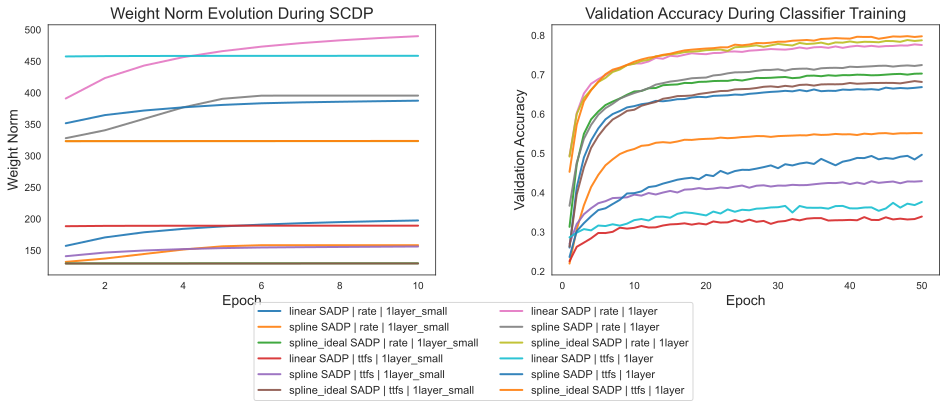

In [5]:
# SUMMARY TABLE (pandas)
df = pd.DataFrame([{
    'Model': r['Model'],
    'Coding': r['Coding'],
    'Classifier': r['Classifier'],
    'Accuracy': r['Accuracy'],
    'F1': r['F1'],
    'Runtime_sec': r['Runtime_sec']
} for r in all_results])

print("\nFinal Benchmark Results:")
print(df.to_markdown(index=False, floatfmt=".4f"))

# save CSV
df.to_csv("scdp_benchmark_results_"+dataset_name+".csv", index=False)

# --- VISUALIZATION: side-by-side plots: weight-norms and val accuracy ---
sns.set_style("white")
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=False)

# colors from seaborn palette (do not hardcode colors)
palette = sns.color_palette("tab10", n_colors=len(all_results))

for i, r in enumerate(all_results):
    label = f"{r['Model']} | {r['Coding']} | {r['Classifier']}"
    # plot weight norms (if available)
    wn = np.asarray(r.get('W_norms', []))
    if wn.size > 0:
        axes[0].plot(range(1, len(wn) + 1), wn, label=label, linewidth=2, alpha=0.9)
axes[0].set_title("Weight Norm Evolution During SCDP", fontsize=16)
axes[0].set_xlabel("Epoch", fontsize=14)
axes[0].set_ylabel("Weight Norm", fontsize=14)
axes[0].grid(False)

for i, r in enumerate(all_results):
    label = f"{r['Model']} | {r['Coding']} | {r['Classifier']}"
    hist = r.get('History', {})
    val_acc = hist.get('val_accuracy') or hist.get('val_acc') or hist.get('accuracy')  # try common keys
    if val_acc:
        axes[1].plot(range(1, len(val_acc) + 1), val_acc, label=label, linewidth=2, alpha=0.9)
axes[1].set_title("Validation Accuracy During Classifier Training", fontsize=16)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].set_ylabel("Validation Accuracy", fontsize=14)
axes[1].grid(False)

# shared legend
fig.legend(
    handles=axes[0].lines + axes[1].lines,
    labels=[f"{r['Model']} | {r['Coding']} | {r['Classifier']}" for r in all_results],
    loc="lower center",
    fontsize=11,
    frameon=True,
    ncol=2
)
plt.subplots_adjust(bottom=0.30, wspace=0.3)
plt.savefig("training_plots_side_by_side_SCDP"+dataset_name+".png", dpi=300, bbox_inches='tight')
plt.show()
